In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('/home/deepstation/PRMLlab/technicakidz/Data/actitracker_down.txt')
#dataset = dataset.replace("\t",",",regex=True)#.replace(';',',')
dataset.shape

(28600, 6)

In [5]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
1769,33,Downstairs,49646322311000,-0.040861,4.985047,6.510526


In [6]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

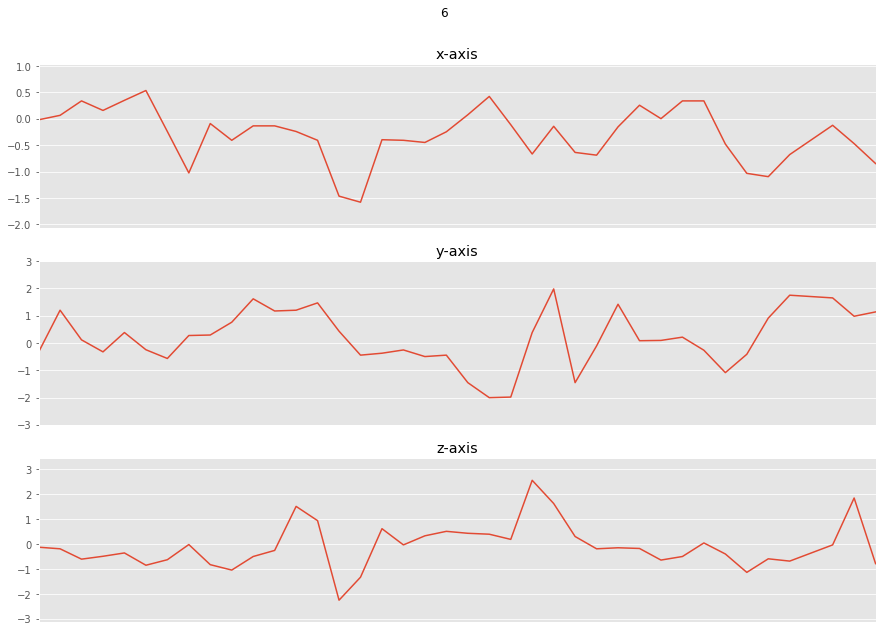

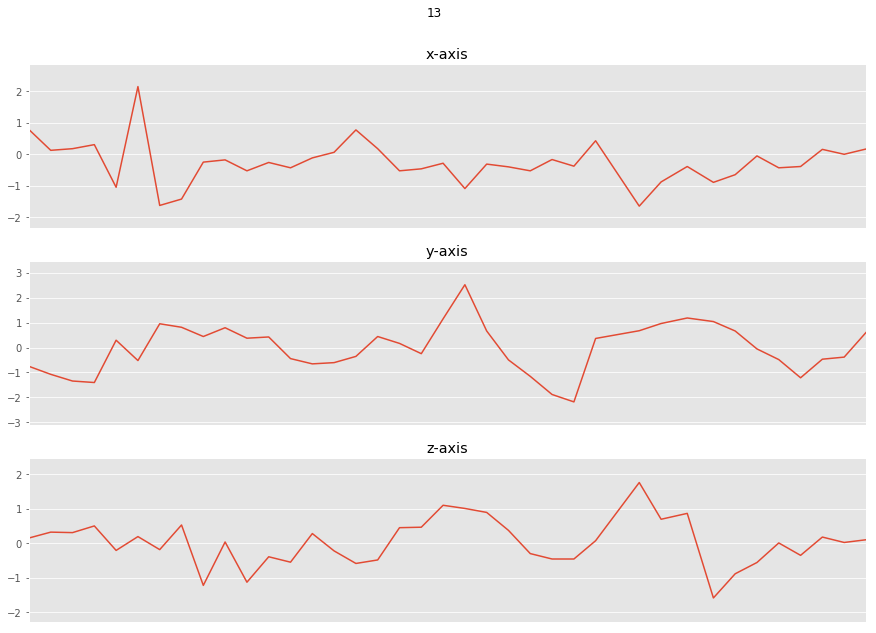

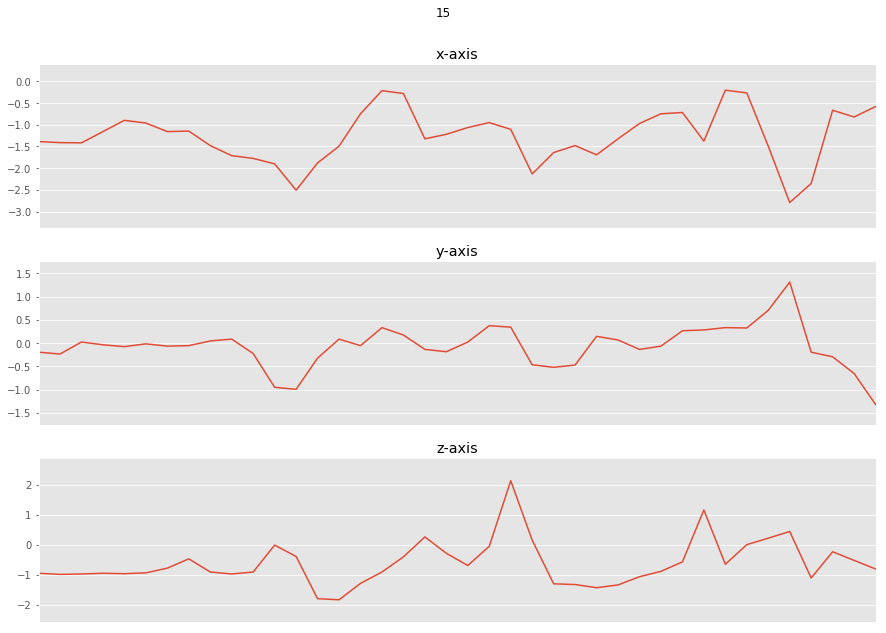

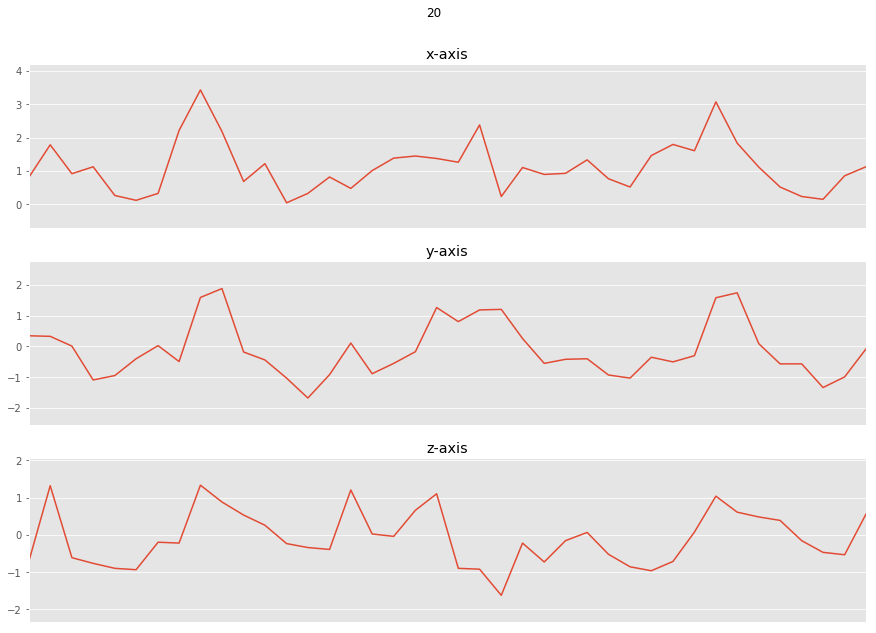

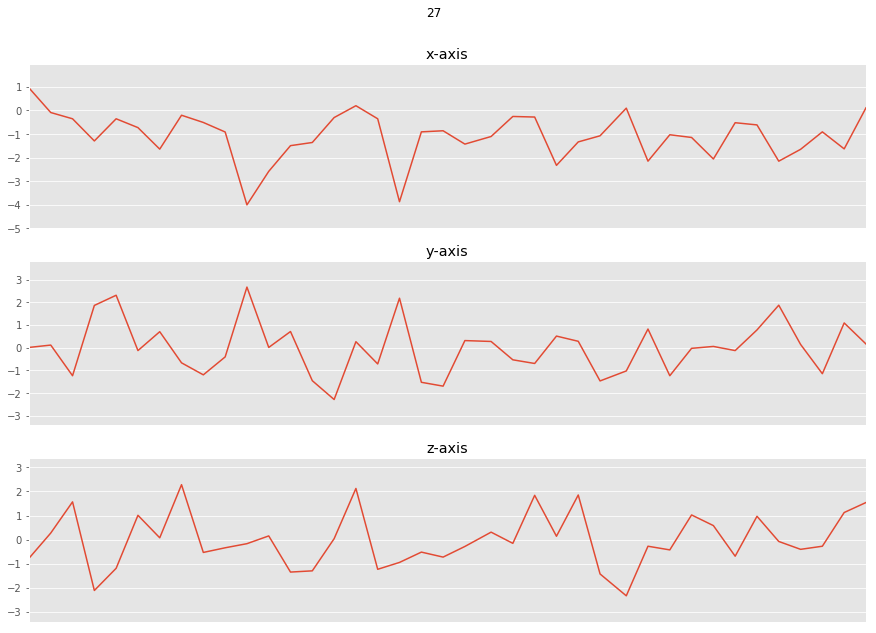

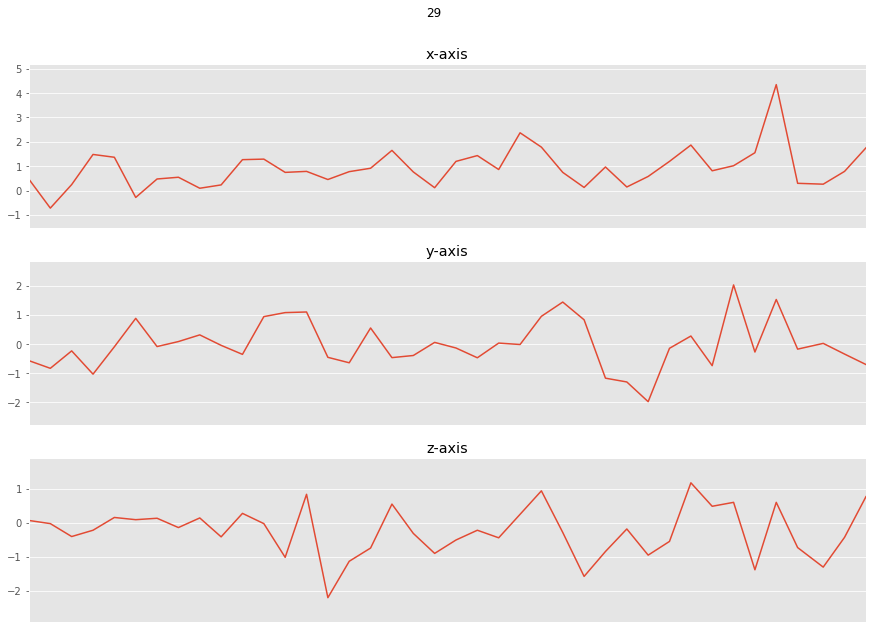

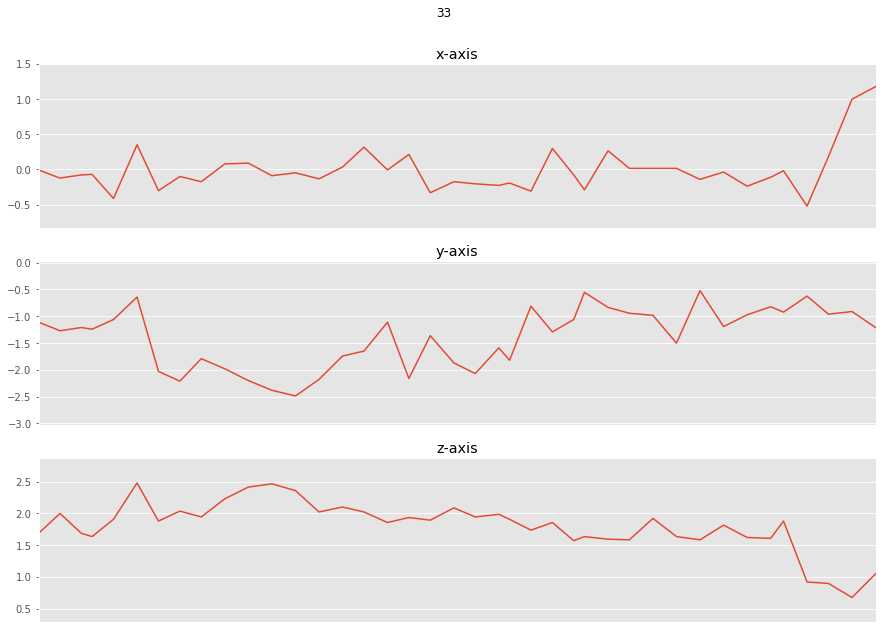

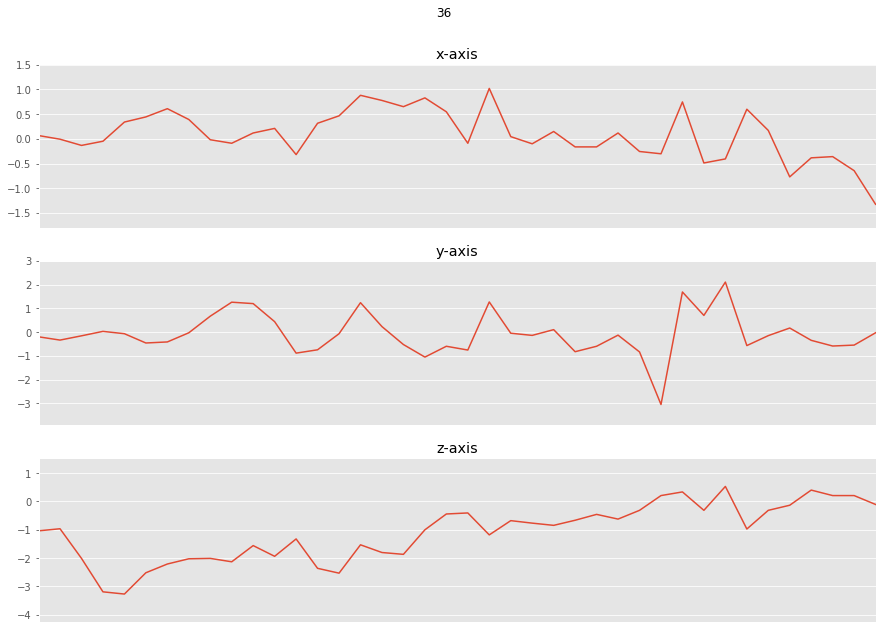

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [8]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [9]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_xd = reshaped_segments[train_test_split]
train_yd = labels[train_test_split]
test_xd = reshaped_segments[~train_test_split]
test_yd = labels[~train_test_split]

In [10]:
#saved data
np.save('train_xd.npy',train_xd)
np.save('train_yd.npy',train_yd)
np.save('test_xd.npy',test_xd)
np.save('test_yd.npy',test_yd)

In [10]:
import numpy as np
train_xd = np.load('train_xd.npy')
train_yd = np.load('train_yd.npy')
test_xd = np.load('test_xd.npy')
test_yd = np.load('test_yd.npy')

In [11]:
#downstairs label
input_height = 1
input_width = 90
num_labels = 8 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xd.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yd.shape[0] - batch_size)
            batch_x = train_xd[offset:(offset + batch_size), :, :, :]
            batch_y = train_yd[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xd, Y: train_yd}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xd, Y: test_yd}))

Epoch:  0  Training Loss:  566.979  Training Accuracy:  0.167038
Epoch:  1  Training Loss:  360.114  Training Accuracy:  0.227171
Epoch:  2  Training Loss:  318.203  Training Accuracy:  0.260579
Epoch:  3  Training Loss:  302.829  Training Accuracy:  0.291759
Epoch:  4  Training Loss:  288.241  Training Accuracy:  0.30735
Epoch:  5  Training Loss:  275.59  Training Accuracy:  0.325167
Epoch:  6  Training Loss:  264.452  Training Accuracy:  0.347439
Epoch:  7  Training Loss:  254.519  Training Accuracy:  0.367483
Epoch:  8  Training Loss:  245.577  Training Accuracy:  0.391982
Epoch:  9  Training Loss:  237.396  Training Accuracy:  0.398664
Epoch:  10  Training Loss:  229.757  Training Accuracy:  0.412027
Epoch:  11  Training Loss:  222.567  Training Accuracy:  0.434298
Epoch:  12  Training Loss:  215.962  Training Accuracy:  0.454343
Epoch:  13  Training Loss:  209.822  Training Accuracy:  0.461024
Epoch:  14  Training Loss:  204.034  Training Accuracy:  0.476615
Epoch:  15  Training L

Epoch:  125  Training Loss:  37.3835  Training Accuracy:  0.817372
Epoch:  126  Training Loss:  37.0565  Training Accuracy:  0.817372
Epoch:  127  Training Loss:  36.7328  Training Accuracy:  0.817372
Epoch:  128  Training Loss:  36.4151  Training Accuracy:  0.817372
Epoch:  129  Training Loss:  36.1046  Training Accuracy:  0.817372
Epoch:  130  Training Loss:  35.796  Training Accuracy:  0.817372
Epoch:  131  Training Loss:  35.4914  Training Accuracy:  0.817372
Epoch:  132  Training Loss:  35.1964  Training Accuracy:  0.817372
Epoch:  133  Training Loss:  34.8986  Training Accuracy:  0.817372
Epoch:  134  Training Loss:  34.6081  Training Accuracy:  0.819599
Epoch:  135  Training Loss:  34.323  Training Accuracy:  0.821826
Epoch:  136  Training Loss:  34.0376  Training Accuracy:  0.824053
Epoch:  137  Training Loss:  33.7586  Training Accuracy:  0.824053
Epoch:  138  Training Loss:  33.4843  Training Accuracy:  0.824053
Epoch:  139  Training Loss:  33.2105  Training Accuracy:  0.8240

Epoch:  248  Training Loss:  16.6012  Training Accuracy:  0.853007
Epoch:  249  Training Loss:  16.516  Training Accuracy:  0.853007
Epoch:  250  Training Loss:  16.4337  Training Accuracy:  0.853007
Epoch:  251  Training Loss:  16.3538  Training Accuracy:  0.853007
Epoch:  252  Training Loss:  16.2706  Training Accuracy:  0.853007
Epoch:  253  Training Loss:  16.1902  Training Accuracy:  0.853007
Epoch:  254  Training Loss:  16.1108  Training Accuracy:  0.853007
Epoch:  255  Training Loss:  16.0316  Training Accuracy:  0.855234
Epoch:  256  Training Loss:  15.9532  Training Accuracy:  0.855234
Epoch:  257  Training Loss:  15.8759  Training Accuracy:  0.855234
Epoch:  258  Training Loss:  15.7983  Training Accuracy:  0.855234
Epoch:  259  Training Loss:  15.7224  Training Accuracy:  0.855234
Epoch:  260  Training Loss:  15.6464  Training Accuracy:  0.855234
Epoch:  261  Training Loss:  15.5708  Training Accuracy:  0.855234
Epoch:  262  Training Loss:  15.4956  Training Accuracy:  0.855

Epoch:  371  Training Loss:  9.94036  Training Accuracy:  0.864143
Epoch:  372  Training Loss:  9.90662  Training Accuracy:  0.864143
Epoch:  373  Training Loss:  9.87147  Training Accuracy:  0.864143
Epoch:  374  Training Loss:  9.83773  Training Accuracy:  0.864143
Epoch:  375  Training Loss:  9.80457  Training Accuracy:  0.864143
Epoch:  376  Training Loss:  9.77046  Training Accuracy:  0.864143
Epoch:  377  Training Loss:  9.73723  Training Accuracy:  0.864143
Epoch:  378  Training Loss:  9.70447  Training Accuracy:  0.864143
Epoch:  379  Training Loss:  9.67079  Training Accuracy:  0.864143
Epoch:  380  Training Loss:  9.63844  Training Accuracy:  0.864143
Epoch:  381  Training Loss:  9.60625  Training Accuracy:  0.864143
Epoch:  382  Training Loss:  9.57375  Training Accuracy:  0.864143
Epoch:  383  Training Loss:  9.54104  Training Accuracy:  0.864143
Epoch:  384  Training Loss:  9.50975  Training Accuracy:  0.864143
Epoch:  385  Training Loss:  9.47789  Training Accuracy:  0.86

Epoch:  494  Training Loss:  6.87947  Training Accuracy:  0.864143
Epoch:  495  Training Loss:  6.8617  Training Accuracy:  0.864143
Epoch:  496  Training Loss:  6.84422  Training Accuracy:  0.864143
Epoch:  497  Training Loss:  6.82632  Training Accuracy:  0.864143
Epoch:  498  Training Loss:  6.80909  Training Accuracy:  0.864143
Epoch:  499  Training Loss:  6.7916  Training Accuracy:  0.864143
Epoch:  500  Training Loss:  6.77394  Training Accuracy:  0.864143
Epoch:  501  Training Loss:  6.75668  Training Accuracy:  0.864143
Epoch:  502  Training Loss:  6.73952  Training Accuracy:  0.864143
Epoch:  503  Training Loss:  6.72224  Training Accuracy:  0.864143
Epoch:  504  Training Loss:  6.70514  Training Accuracy:  0.864143
Epoch:  505  Training Loss:  6.68848  Training Accuracy:  0.864143
Epoch:  506  Training Loss:  6.67135  Training Accuracy:  0.864143
Epoch:  507  Training Loss:  6.6543  Training Accuracy:  0.864143
Epoch:  508  Training Loss:  6.63796  Training Accuracy:  0.86414

Epoch:  617  Training Loss:  5.17653  Training Accuracy:  0.864143
Epoch:  618  Training Loss:  5.16572  Training Accuracy:  0.864143
Epoch:  619  Training Loss:  5.15521  Training Accuracy:  0.864143
Epoch:  620  Training Loss:  5.14468  Training Accuracy:  0.864143
Epoch:  621  Training Loss:  5.13403  Training Accuracy:  0.864143
Epoch:  622  Training Loss:  5.12388  Training Accuracy:  0.864143
Epoch:  623  Training Loss:  5.11334  Training Accuracy:  0.864143
Epoch:  624  Training Loss:  5.1028  Training Accuracy:  0.864143
Epoch:  625  Training Loss:  5.09237  Training Accuracy:  0.864143
Epoch:  626  Training Loss:  5.08197  Training Accuracy:  0.864143
Epoch:  627  Training Loss:  5.07166  Training Accuracy:  0.864143
Epoch:  628  Training Loss:  5.06171  Training Accuracy:  0.864143
Epoch:  629  Training Loss:  5.05139  Training Accuracy:  0.864143
Epoch:  630  Training Loss:  5.04113  Training Accuracy:  0.864143
Epoch:  631  Training Loss:  5.03094  Training Accuracy:  0.864

Epoch:  740  Training Loss:  4.11036  Training Accuracy:  0.864143
Epoch:  741  Training Loss:  4.10343  Training Accuracy:  0.864143
Epoch:  742  Training Loss:  4.09642  Training Accuracy:  0.864143
Epoch:  743  Training Loss:  4.08933  Training Accuracy:  0.864143
Epoch:  744  Training Loss:  4.08247  Training Accuracy:  0.864143
Epoch:  745  Training Loss:  4.0754  Training Accuracy:  0.864143
Epoch:  746  Training Loss:  4.06864  Training Accuracy:  0.864143
Epoch:  747  Training Loss:  4.06175  Training Accuracy:  0.864143
Epoch:  748  Training Loss:  4.05477  Training Accuracy:  0.864143
Epoch:  749  Training Loss:  4.04791  Training Accuracy:  0.864143
Epoch:  750  Training Loss:  4.04111  Training Accuracy:  0.864143
Epoch:  751  Training Loss:  4.03425  Training Accuracy:  0.864143
Epoch:  752  Training Loss:  4.02759  Training Accuracy:  0.864143
Epoch:  753  Training Loss:  4.02078  Training Accuracy:  0.864143
Epoch:  754  Training Loss:  4.01387  Training Accuracy:  0.864

Epoch:  863  Training Loss:  3.38432  Training Accuracy:  0.864143
Epoch:  864  Training Loss:  3.37929  Training Accuracy:  0.864143
Epoch:  865  Training Loss:  3.37437  Training Accuracy:  0.864143
Epoch:  866  Training Loss:  3.36946  Training Accuracy:  0.864143
Epoch:  867  Training Loss:  3.3645  Training Accuracy:  0.864143
Epoch:  868  Training Loss:  3.3596  Training Accuracy:  0.864143
Epoch:  869  Training Loss:  3.35468  Training Accuracy:  0.864143
Epoch:  870  Training Loss:  3.34974  Training Accuracy:  0.864143
Epoch:  871  Training Loss:  3.34498  Training Accuracy:  0.864143
Epoch:  872  Training Loss:  3.34004  Training Accuracy:  0.864143
Epoch:  873  Training Loss:  3.33515  Training Accuracy:  0.864143
Epoch:  874  Training Loss:  3.33036  Training Accuracy:  0.864143
Epoch:  875  Training Loss:  3.32554  Training Accuracy:  0.864143
Epoch:  876  Training Loss:  3.32078  Training Accuracy:  0.864143
Epoch:  877  Training Loss:  3.31581  Training Accuracy:  0.8641

Epoch:  986  Training Loss:  2.86043  Training Accuracy:  0.864143
Epoch:  987  Training Loss:  2.85686  Training Accuracy:  0.864143
Epoch:  988  Training Loss:  2.8532  Training Accuracy:  0.864143
Epoch:  989  Training Loss:  2.84961  Training Accuracy:  0.864143
Epoch:  990  Training Loss:  2.84603  Training Accuracy:  0.864143
Epoch:  991  Training Loss:  2.84239  Training Accuracy:  0.864143
Epoch:  992  Training Loss:  2.8388  Training Accuracy:  0.864143
Epoch:  993  Training Loss:  2.83521  Training Accuracy:  0.864143
Epoch:  994  Training Loss:  2.83167  Training Accuracy:  0.864143
Epoch:  995  Training Loss:  2.82811  Training Accuracy:  0.864143
Epoch:  996  Training Loss:  2.82452  Training Accuracy:  0.864143
Epoch:  997  Training Loss:  2.82104  Training Accuracy:  0.864143
Epoch:  998  Training Loss:  2.81746  Training Accuracy:  0.864143
Epoch:  999  Training Loss:  2.81392  Training Accuracy:  0.864143
Epoch:  1000  Training Loss:  2.81041  Training Accuracy:  0.864

Epoch:  1107  Training Loss:  2.47549  Training Accuracy:  0.864143
Epoch:  1108  Training Loss:  2.47272  Training Accuracy:  0.864143
Epoch:  1109  Training Loss:  2.46996  Training Accuracy:  0.864143
Epoch:  1110  Training Loss:  2.46715  Training Accuracy:  0.864143
Epoch:  1111  Training Loss:  2.46443  Training Accuracy:  0.864143
Epoch:  1112  Training Loss:  2.46165  Training Accuracy:  0.864143
Epoch:  1113  Training Loss:  2.45889  Training Accuracy:  0.864143
Epoch:  1114  Training Loss:  2.45614  Training Accuracy:  0.864143
Epoch:  1115  Training Loss:  2.45342  Training Accuracy:  0.864143
Epoch:  1116  Training Loss:  2.4507  Training Accuracy:  0.864143
Epoch:  1117  Training Loss:  2.44793  Training Accuracy:  0.864143
Epoch:  1118  Training Loss:  2.44523  Training Accuracy:  0.864143
Epoch:  1119  Training Loss:  2.44252  Training Accuracy:  0.864143
Epoch:  1120  Training Loss:  2.43982  Training Accuracy:  0.864143
Epoch:  1121  Training Loss:  2.43709  Training A

Epoch:  1228  Training Loss:  2.17612  Training Accuracy:  0.864143
Epoch:  1229  Training Loss:  2.17399  Training Accuracy:  0.864143
Epoch:  1230  Training Loss:  2.17176  Training Accuracy:  0.864143
Epoch:  1231  Training Loss:  2.16959  Training Accuracy:  0.864143
Epoch:  1232  Training Loss:  2.16742  Training Accuracy:  0.864143
Epoch:  1233  Training Loss:  2.16523  Training Accuracy:  0.864143
Epoch:  1234  Training Loss:  2.16307  Training Accuracy:  0.864143
Epoch:  1235  Training Loss:  2.16086  Training Accuracy:  0.864143
Epoch:  1236  Training Loss:  2.15874  Training Accuracy:  0.864143
Epoch:  1237  Training Loss:  2.1566  Training Accuracy:  0.864143
Epoch:  1238  Training Loss:  2.1544  Training Accuracy:  0.864143
Epoch:  1239  Training Loss:  2.15227  Training Accuracy:  0.864143
Epoch:  1240  Training Loss:  2.15012  Training Accuracy:  0.864143
Epoch:  1241  Training Loss:  2.14799  Training Accuracy:  0.864143
Epoch:  1242  Training Loss:  2.14581  Training Ac

Epoch:  1349  Training Loss:  1.9374  Training Accuracy:  0.864143
Epoch:  1350  Training Loss:  1.93564  Training Accuracy:  0.864143
Epoch:  1351  Training Loss:  1.93384  Training Accuracy:  0.864143
Epoch:  1352  Training Loss:  1.9321  Training Accuracy:  0.864143
Epoch:  1353  Training Loss:  1.93033  Training Accuracy:  0.864143
Epoch:  1354  Training Loss:  1.92855  Training Accuracy:  0.864143
Epoch:  1355  Training Loss:  1.9268  Training Accuracy:  0.864143
Epoch:  1356  Training Loss:  1.92504  Training Accuracy:  0.864143
Epoch:  1357  Training Loss:  1.9233  Training Accuracy:  0.864143
Epoch:  1358  Training Loss:  1.92152  Training Accuracy:  0.864143
Epoch:  1359  Training Loss:  1.91979  Training Accuracy:  0.864143
Epoch:  1360  Training Loss:  1.91804  Training Accuracy:  0.864143
Epoch:  1361  Training Loss:  1.91631  Training Accuracy:  0.864143
Epoch:  1362  Training Loss:  1.91456  Training Accuracy:  0.864143
Epoch:  1363  Training Loss:  1.91281  Training Accu

Epoch:  1470  Training Loss:  1.74217  Training Accuracy:  0.864143
Epoch:  1471  Training Loss:  1.74072  Training Accuracy:  0.864143
Epoch:  1472  Training Loss:  1.73925  Training Accuracy:  0.864143
Epoch:  1473  Training Loss:  1.7378  Training Accuracy:  0.864143
Epoch:  1474  Training Loss:  1.73634  Training Accuracy:  0.864143
Epoch:  1475  Training Loss:  1.73488  Training Accuracy:  0.864143
Epoch:  1476  Training Loss:  1.73343  Training Accuracy:  0.864143
Epoch:  1477  Training Loss:  1.73199  Training Accuracy:  0.864143
Epoch:  1478  Training Loss:  1.73055  Training Accuracy:  0.864143
Epoch:  1479  Training Loss:  1.72908  Training Accuracy:  0.864143
Epoch:  1480  Training Loss:  1.72766  Training Accuracy:  0.864143
Epoch:  1481  Training Loss:  1.72623  Training Accuracy:  0.864143
Epoch:  1482  Training Loss:  1.72477  Training Accuracy:  0.864143
Epoch:  1483  Training Loss:  1.72335  Training Accuracy:  0.864143
Epoch:  1484  Training Loss:  1.72191  Training A

Epoch:  1591  Training Loss:  1.58023  Training Accuracy:  0.864143
Epoch:  1592  Training Loss:  1.57902  Training Accuracy:  0.864143
Epoch:  1593  Training Loss:  1.57778  Training Accuracy:  0.864143
Epoch:  1594  Training Loss:  1.57656  Training Accuracy:  0.864143
Epoch:  1595  Training Loss:  1.57534  Training Accuracy:  0.864143
Epoch:  1596  Training Loss:  1.57413  Training Accuracy:  0.864143
Epoch:  1597  Training Loss:  1.5729  Training Accuracy:  0.864143
Epoch:  1598  Training Loss:  1.57169  Training Accuracy:  0.864143
Epoch:  1599  Training Loss:  1.57048  Training Accuracy:  0.864143
Epoch:  1600  Training Loss:  1.56929  Training Accuracy:  0.864143
Epoch:  1601  Training Loss:  1.56809  Training Accuracy:  0.864143
Epoch:  1602  Training Loss:  1.56688  Training Accuracy:  0.864143
Epoch:  1603  Training Loss:  1.56568  Training Accuracy:  0.864143
Epoch:  1604  Training Loss:  1.56448  Training Accuracy:  0.864143
Epoch:  1605  Training Loss:  1.56328  Training A

Epoch:  1712  Training Loss:  1.44396  Training Accuracy:  0.864143
Epoch:  1713  Training Loss:  1.44291  Training Accuracy:  0.864143
Epoch:  1714  Training Loss:  1.44189  Training Accuracy:  0.864143
Epoch:  1715  Training Loss:  1.44085  Training Accuracy:  0.864143
Epoch:  1716  Training Loss:  1.43983  Training Accuracy:  0.864143
Epoch:  1717  Training Loss:  1.43879  Training Accuracy:  0.864143
Epoch:  1718  Training Loss:  1.43776  Training Accuracy:  0.864143
Epoch:  1719  Training Loss:  1.43673  Training Accuracy:  0.864143
Epoch:  1720  Training Loss:  1.43571  Training Accuracy:  0.864143
Epoch:  1721  Training Loss:  1.43468  Training Accuracy:  0.864143
Epoch:  1722  Training Loss:  1.43366  Training Accuracy:  0.864143
Epoch:  1723  Training Loss:  1.43265  Training Accuracy:  0.864143
Epoch:  1724  Training Loss:  1.43161  Training Accuracy:  0.864143
Epoch:  1725  Training Loss:  1.4306  Training Accuracy:  0.864143
Epoch:  1726  Training Loss:  1.42959  Training A

Epoch:  1833  Training Loss:  1.32798  Training Accuracy:  0.864143
Epoch:  1834  Training Loss:  1.32709  Training Accuracy:  0.864143
Epoch:  1835  Training Loss:  1.32621  Training Accuracy:  0.864143
Epoch:  1836  Training Loss:  1.32533  Training Accuracy:  0.864143
Epoch:  1837  Training Loss:  1.32445  Training Accuracy:  0.864143
Epoch:  1838  Training Loss:  1.32355  Training Accuracy:  0.864143
Epoch:  1839  Training Loss:  1.32269  Training Accuracy:  0.864143
Epoch:  1840  Training Loss:  1.32179  Training Accuracy:  0.864143
Epoch:  1841  Training Loss:  1.32092  Training Accuracy:  0.864143
Epoch:  1842  Training Loss:  1.32004  Training Accuracy:  0.864143
Epoch:  1843  Training Loss:  1.31917  Training Accuracy:  0.864143
Epoch:  1844  Training Loss:  1.31829  Training Accuracy:  0.864143
Epoch:  1845  Training Loss:  1.31742  Training Accuracy:  0.864143
Epoch:  1846  Training Loss:  1.31654  Training Accuracy:  0.864143
Epoch:  1847  Training Loss:  1.31566  Training 

Epoch:  1954  Training Loss:  1.22835  Training Accuracy:  0.864143
Epoch:  1955  Training Loss:  1.22757  Training Accuracy:  0.864143
Epoch:  1956  Training Loss:  1.22681  Training Accuracy:  0.864143
Epoch:  1957  Training Loss:  1.22604  Training Accuracy:  0.864143
Epoch:  1958  Training Loss:  1.22528  Training Accuracy:  0.864143
Epoch:  1959  Training Loss:  1.22453  Training Accuracy:  0.864143
Epoch:  1960  Training Loss:  1.22377  Training Accuracy:  0.864143
Epoch:  1961  Training Loss:  1.22301  Training Accuracy:  0.864143
Epoch:  1962  Training Loss:  1.22226  Training Accuracy:  0.864143
Epoch:  1963  Training Loss:  1.2215  Training Accuracy:  0.864143
Epoch:  1964  Training Loss:  1.22074  Training Accuracy:  0.864143
Epoch:  1965  Training Loss:  1.21999  Training Accuracy:  0.864143
Epoch:  1966  Training Loss:  1.21923  Training Accuracy:  0.864143
Epoch:  1967  Training Loss:  1.21849  Training Accuracy:  0.864143
Epoch:  1968  Training Loss:  1.21773  Training A

In [ ]:
batch_x.shape

In [ ]:
batch_y.shape

In [ ]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xd.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xd[offset:(offset + batch_size), :, :, :]
            batch_y = train_yd[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xd, Y: train_yd}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xd, Y: test_yd}))

In [ ]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))